In [1]:
%cd ../..

/home/zilian/projects/bachelorproef


/home/zilian/projects/bachelorproef/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
from src.api.jobs.gaze_segmentation import GazeSegmentationJob
import numpy as np
from src.db import engine
from sqlalchemy.orm import Session
from src.db.models import Recording, SimRoomClass
import matplotlib.pyplot as plt
from src.utils import extract_frames_to_dir
import src.api.jobs.generate_embeddings as generate_embeddings 
import time

E0000 00:00:1742155411.253412   23407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742155411.256343   23407 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
with Session(engine) as session:
    recording = Recording.get("39f5164f-873d-4d6b-be6b-e1d5db79c02a")
    if recording is None:
        raise ValueError("Recording not found")

    video_path = recording.video_path
    gaze_data_path = recording.gaze_data_path
    
class_id_to_name = SimRoomClass.get_id_to_name_map()

In [4]:
RECORDING_FRAMES_PATH = Path("notebooks/analysis-pipeline/data/recording_frames")
RESULTS_PATH = Path("notebooks/analysis-pipeline/data/gaze_segmentation_results")
RESULTS_PATH.mkdir(exist_ok=True)

if not list(RECORDING_FRAMES_PATH.glob("*.jpg")):
    extract_frames_to_dir(video_path, RECORDING_FRAMES_PATH)

if len(list(RESULTS_PATH.iterdir())) == 0:
    gaze_sam_job = GazeSegmentationJob(
        video_path=video_path,
        gaze_data_path=gaze_data_path,
        results_path=RESULTS_PATH,
        frames_path=RECORDING_FRAMES_PATH,
    )

    gaze_sam_job.process_batches()

RESULT_VIDEO_PATH = Path("notebooks/analysis-pipeline/data/gaze_output.mp4")
if not RESULT_VIDEO_PATH.exists():
    gaze_sam_job.create_video_from_results(RESULT_VIDEO_PATH)

Batches: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]

Total batch load time: 3.24 seconds
Total inference time: 23.11 seconds
Total postprocess time: 10.07 seconds


In [5]:
gaze_segmentation_results = list(RESULTS_PATH.iterdir())
gaze_segmentation_results.sort(key=lambda x: int(x.stem))

rois_per_frame = []

for result_path in gaze_segmentation_results:
    result = np.load(result_path, allow_pickle=True)
    rois_per_frame.append(result["rois"])

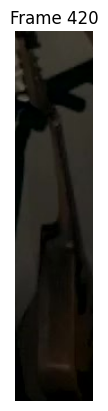

In [45]:
frame_idx = 420
for i, rois in enumerate(rois_per_frame):
    if i != frame_idx:
        continue
    plt.imshow(rois[0])
    plt.axis("off")
    plt.title(f"Frame {i}")
    plt.show()
    break

In [7]:
dinov2 = generate_embeddings.load_model()
index = generate_embeddings.read_index(Path("notebooks/analysis-pipeline/data/embeddings.index"))

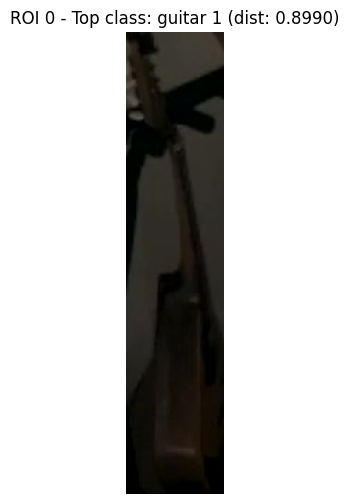

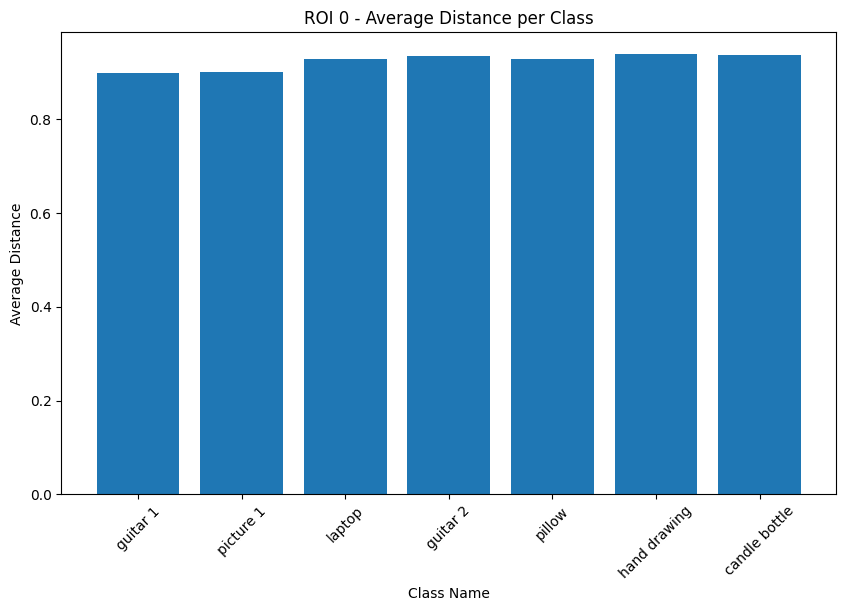

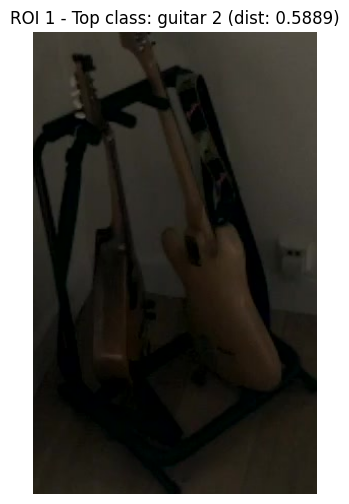

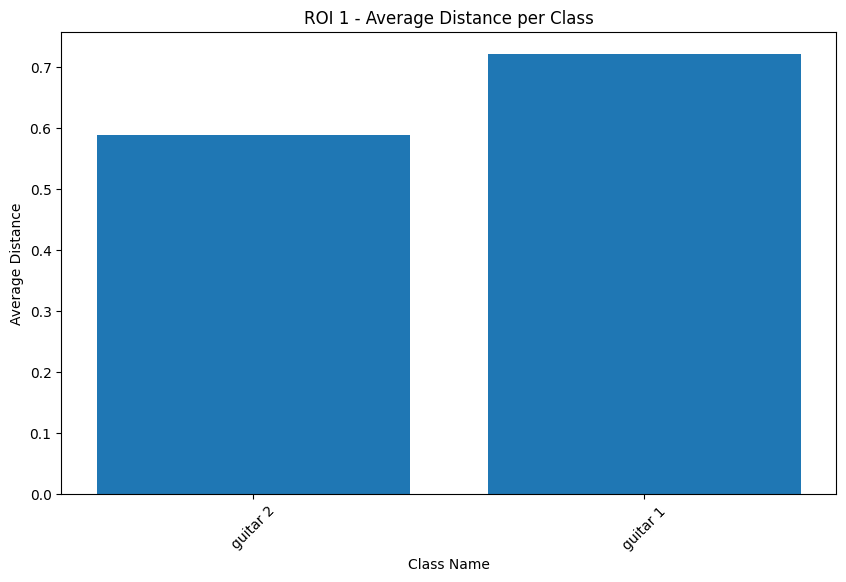

In [46]:
rois = rois_per_frame[frame_idx]
embeddings, _, _ = list(generate_embeddings.get_embeddings(dinov2, rois))[0]
distances, indices = generate_embeddings.search_index(index, embeddings, k=50)

for i, (roi, embedding) in enumerate(zip(rois, embeddings)):
    D, I = distances[i], indices[i]
    # Map class IDs to names
    class_names = [class_id_to_name[idx] for idx in I]
    
    # Group by class name to calculate average distance
    class_to_distances = {}
    for class_idx, distance in zip(I, D):
        class_name = class_id_to_name[class_idx]
        class_to_distances.setdefault(class_name, []).append(distance)
    
    # Compute average distance for each class
    avg_distances = {cls: sum(dists) / len(dists) for cls, dists in class_to_distances.items()}
    sorted_classes = sorted(avg_distances.items(), key=lambda x: x[1])
    
    # Plot the ROI with the top class indicated in the title
    plt.figure(figsize=(10, 6))
    plt.imshow(roi)
    plt.title(f"ROI {i} - Top class: {sorted_classes[0][0]} (dist: {sorted_classes[0][1]:.4f})")
    plt.axis('off')
    plt.show()
    
    # Create a bar chart for average distance per class name
    plt.figure(figsize=(10, 6))
    classes = list(avg_distances.keys())
    avg_vals = [avg_distances[cls] for cls in classes]
    plt.bar(classes, avg_vals)
    plt.xticks(rotation=45)
    plt.xlabel("Class Name")
    plt.ylabel("Average Distance")
    plt.title(f"ROI {i} - Average Distance per Class")
    plt.show()


In [9]:
# start = time.time()

# # TODO: implement batching
# for frame_idx, rois in enumerate(rois_per_frame):
#     if len(rois) == 0:
#         continue

#     embeddings, _, _ = list(generate_embeddings.get_embeddings(dinov2, rois, log_performance=False))[0]

# frame_count = len(rois_per_frame)
# fps = frame_count / (time.time() - start)
# print(f"Calculated embeddings for {len(rois_per_frame)} frames at {fps:.2f} fps")